In [1]:
import numpy as np
import pandas as pd

In [2]:
import src.visualize_tools as vt
import src.framework_utils as fu

In [3]:
!nvidia-smi

Wed Nov  8 13:31:14 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0 Off |                  Off |
|  0%   56C    P8              33W / 450W |      3MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import tensorflow as tf
print(f'tensorflow version {tf.__version__}')
print(f"Divce: {tf.config.list_physical_devices('GPU')}")

tensorflow version 2.4.0
Divce: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Step 1: Data Preparation

In this first step, we will prepare the data for our analysis. We have provided four example scans (preprocessed) from two subjects, which are sourced from the [OASIS-3 dataset](https://www.oasis-brains.org/#data). These scans are available in the `.npz` format and are located in the `./example` directory. 

Before proceeding, it's essential to ensure that you have obtained the necessary permissions to access and use the data from the OASIS-3 dataset. Please review and accept the [Data Agreement](https://www.oasis-brains.org/#access) on the OASIS-3 webpage to comply with their terms and conditions.

You have the flexibility to replace the provided scans in the subsequent cell to suit your specific needs.

Size of the data is (208, 176, 160)


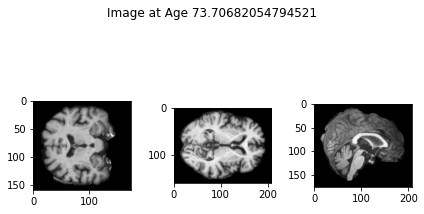

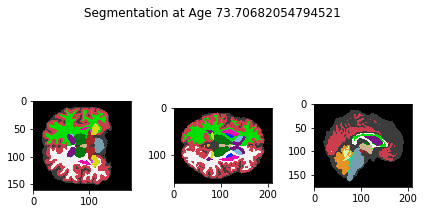

In [5]:
# Load Example .npz Data
# This function loads an example scan from a provided .npz file. It extracts three main elements: image, segmentation, and age.
def load_npz(npz_file):
    img = np.load(npz_file)['vol']
    print(f'Size of the data is {img.shape}')
    age = np.load(npz_file)['age']
    seg = np.load(npz_file)['synth_seg']

    # Display the 3D image and segmentation with age information
    vt.show_3d_mid(img, title=f'Image at Age {age}')
    vt.show_3d_mid(seg, cmap=vt.create_new_cmap(), title=f'Segmentation at Age {age}')
    return img, seg, age

# Load Clinical Dementia Rating (CDR) for a Subject
# This function loads the Clinical Dementia Rating (CDR) for a specific subject at a given age.
def load_cdr_forSubject(cdr_csv_path, subject_id, age):
    df = pd.read_csv(cdr_csv_path)
    sub = {}

    # Extract relevant data for the specified subject
    for head in df.head():
        sub[head] = df[head][df["OASISID"] == subject_id]

    # Find the nearest age match in the dataset
    index = np.argmin(np.abs(sub["age at visit"] - age))
    output = np.array(sub["CDRTOT"])[index]
    return output

# Load an Example Scan and CDR Information
example_scan = './example/OAS30964_d2772.npz'  # Change to another file if needed
# Specify the main path where additional resources are located
main_path = './src/' # The average image is provided as "linearaverageof100.npz" in the './src' directory
scan_img, scan_seg, scan_age = load_npz(example_scan)
scan_cdr = load_cdr_forSubject(f'{main_path}OASIS3_UDSb4_cdr.csv', example_scan[10:18], scan_age)

# Step 2: Pre-Trained Normal Aging Generator

In this step, we make use of a pre-trained normal aging template generator and registrator to aid in our analysis. These tools are available in the `.src/framework_utils.py` file.

To incorporate these pre-trained models into your analysis, follow the steps below:

1. Import the necessary functions and classes from `.src/framework_utils.py`.
2. Initialize the generator and registrator objects.
3. Utilize these pre-trained models for generating normal aging templates and conducting registrations as needed for your study.

This pre-trained framework simplifies the process of generating and registering normal aging templates, saving you valuable time and resources.

In [6]:
# Load Pre-Trained Weight for Template Generator and Generate a Normal Aging Template
# Define the path to the pre-trained model checkpoint
checkpoint_path = './models/gploss_1e_4_dataset_OASIS3_single_cohort_eps300_Gconfig_ours_normreg_True_lrg0.0001_lrd0.0003_cond_True_regloss_NCC_lbdgan_0.1_lbdreg_1.0_lbdtv_0.0_lbdgp_0.0001_dsnout_False_start_0_clip_True/'

# Generate a Cognitive Normal (CN) template brain at age 60 using the template generator
T60 = fu.template_generator(main_path, 60, checkpoint_path)

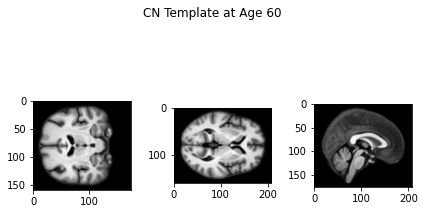

In [7]:
# Display the Learned Cognitive Normal (CN) Template at Age 60
vt.show_3d_mid(T60, title=f'CN Template at Age 60')

## Visual Demonstration: Cognitive Normal (CN) Templates

To facilitate your research and analysis, we have prepared a series of CN templates and their corresponding segmentation masks. These templates span from age 60 to 90 and are available in the `./example/CN_templates/` directory.

You can view a visual representation of these CN templates in the animated GIF below, which showcases the normal aging process:

![Normal Aging Templates](./example/CN_templates/Normal_Aging.gif)

# Step 3: Calculate One-Year Atrophy and Register Scans to T60

In this step, we focus on two critical tasks:

1. **Calculate One-Year Normal Aging Atrophy:** We will compute the one-year atrophy from CN templates. 

2. **Register Scans to T60:** We will perform image registration to align the provided scan with the Cognitive Normal (CN) template at age 60 (T60). 

After completing these tasks, we will calculate two scores for assessing brain atrophy in both normal aging and AD-specific directions. Let's proceed with the calculations.

In [8]:
# Load Cognitive Normal (CN) Templates and Segmentation Masks
# We load CN templates and their corresponding segmentation masks for ages 60 and 90.
CN_templates_path = './example/CN_templates/'
T60 = np.transpose(vt.load_nii(f'{CN_templates_path}age_60disease_0.nii.gz'), (2, 1, 0))
T90 = np.transpose(vt.load_nii(f'{CN_templates_path}age_90disease_0.nii.gz'), (2, 1, 0))
T60_Seg = np.transpose(vt.load_nii(f'{CN_templates_path}age_60disease_0_SynthSeg.nii.gz'), (2, 1, 0))
T90_Seg = np.transpose(vt.load_nii(f'{CN_templates_path}age_90disease_0_SynthSeg.nii.gz'), (2, 1, 0))

In [9]:
# Register Scans and Calculate Stationary Velocity Field (SVF)
# We use the registrator to register the T90 scan to T60 and calculate the stationary velocity field (SVF).
_, _, _, vel_half = fu.registrator(T90, T60, checkpoint_path, main_path, n_condns=1, output_vel=True) # Invert

# Calculate One-Year Atrophy
# We convert the velocity field to one-year atrophy values.
svf_u0 = vel_half.numpy() / 30

loading end


In [10]:
# Register Example Scan to T60 Template
# We use the registrator to register the provided example_scan to the T60 template and calculate the stationary velocity field (SVF).
_, _, _, vel_half = fu.registrator(scan_img, T60, checkpoint_path, main_path, n_condns=1, output_vel=True) # Invert

# Convert Velocity Field to Numpy Array
# We convert the velocity field to a NumPy array for further processing and analysis.
vel_half = vel_half.numpy()

loading end


## Calculating Regional Two Scores: AS and ADS

At this stage, we have gathered all the necessary components to compute two scores in regions: the Aging Score (AS) and the AD-specific Score (ADS).

To ensure the accuracy of our analysis, we employ an Outlier Rejection strategy. It's important to note that for different brain regions, we choose optimal quantiles to fine-tune the rejection process. More comprehensive details about this strategy can be found in our research paper, which you can access [here](link_to_paper).

Now, let's proceed with the calculation of AS and ADS scores for your analysis.

In [11]:
# Define Labels for Ventricles and Hippocampus Regions
labels_ventricles = [4, 14, 15, 43]
labels_hippocampus = [17, 53, 18, 54]

# Define Optimal Quantiles for Each Region (As Described in the Paper)
opt_quantiles = [0.9, 0.2, 0.9, 0.0]  # Optimal quantiles obtained from the dataset

# Calculate Biomarkers for Whole Brain Region
scan_markers_WB = fu.calcu_biomarkers("wholebrain", T60_Seg[::2, ::2, ::2], vel_half.squeeze(), svf_u0.squeeze(), opt_quantiles[0])

# Calculate Biomarkers for Ventricles Region
scan_markers_Ven = fu.calcu_biomarkers(labels_ventricles, T60_Seg[::2, ::2, ::2], vel_half.squeeze(), svf_u0.squeeze(), opt_quantiles[1])

# Calculate Biomarkers for Hippocampus Region
scan_markers_Hipp = fu.calcu_biomarkers(labels_hippocampus, T60_Seg[::2, ::2, ::2], vel_half.squeeze(), svf_u0.squeeze(), opt_quantiles[2])

# Calculate Biomarkers for the Difference Between Ventricles at Ages 60 and 90
scan_markers_VenDiff = fu.calcu_biomarkers('diff_ventricles', [T60_Seg[::2, ::2, ::2], T90_Seg[::2, ::2, ::2]], vel_half.squeeze(), svf_u0.squeeze(), opt_quantiles[3])

# Step 4: Correct and Compare with the Dataset

In this final step, we perform corrections and comparisons to ensure the accuracy and reliability of our results. To facilitate this process, we offer the results of all 1014 scans from the dataset. Additionally, we highlight the results of the `example_scan` directly on top of the figure presented in our paper (you can access [here](link_to_paper)).

Let's proceed with the correction and comparison process to validate our findings.


In [12]:
# Define the path to the dataset results
results_dataset = './src/Vel30_invert_AllTest_11interval_results_1014.csv'

# Load the dataset results
datasets = pd.read_csv(results_dataset)

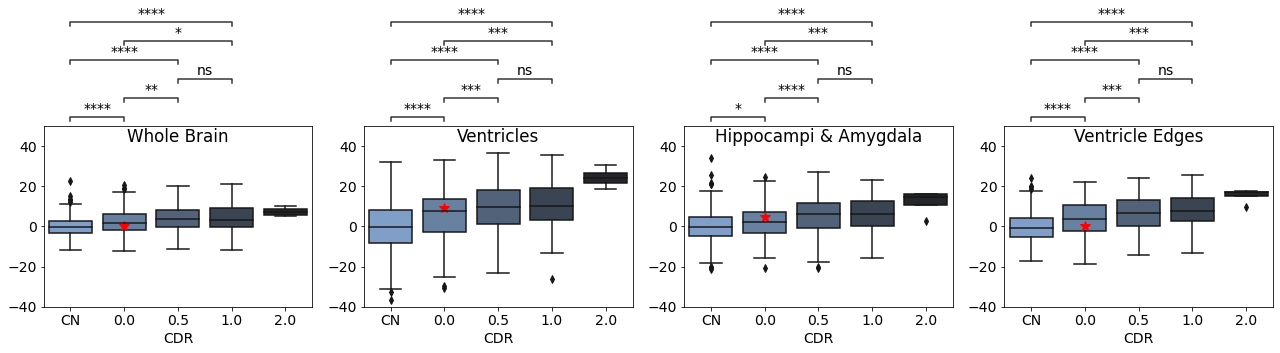

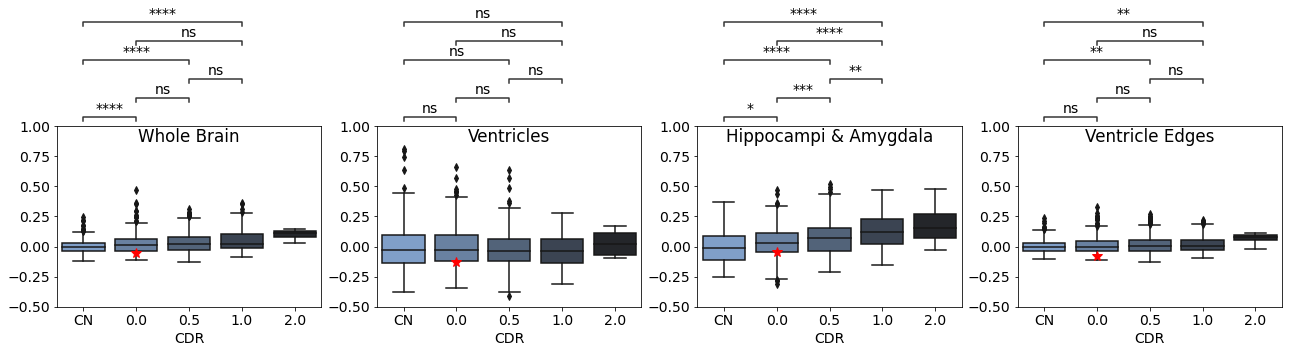

Whole Brain:
AS = 0.4024707678128685, ADS = -0.05584592303645519
Ventricles:
AS = 9.424388934664194, ADS = -0.12702642277895748
Hippocampus and Amygdala:
AS = 4.915926734471647, ADS = -0.042489625063659386
Ventricles Edge:
AS = 0.20495017678287297, ADS = -0.08242110837333727


In [13]:
# List of scan scores for AS and ADS
scan_scores = [scan_markers_WB, scan_markers_Ven, scan_markers_Hipp, scan_markers_VenDiff]

# Calculate Adjusted AS (Aging Score) and ADS (AD-specific Score)
# These scores are adjusted using the dataset and optimal quantiles
adj_AS = fu.plot_adjusted_scores_on_regions(datasets, opt_quantiles, 'hc', scan_scores, scan_age, scan_cdr)
adj_ADS = fu.plot_adjusted_scores_on_regions(datasets, opt_quantiles, 'ad', scan_scores, scan_age, scan_cdr)

# Print the results
print('Whole Brain:')
print(f'AS = {adj_AS[0][0]}, ADS = {adj_ADS[0][1]}')
print('Ventricles:')
print(f'AS = {adj_AS[1][0]}, ADS = {adj_ADS[1][1]}')
print('Hippocampus and Amygdala:')
print(f'AS = {adj_AS[2][0]}, ADS = {adj_ADS[2][1]}')
print('Ventricles Edge:')
print(f'AS = {adj_AS[3][0]}, ADS = {adj_ADS[3][1]}')